# Write python code for training tasks

## Goal

Write python code that implements training tasks and also creates the input distributions.

## Imports

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys
import os
import glob
import json
import random
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm.auto import tqdm

# add path to python path
sys.path.append(os.path.realpath('../scripts/'))
from arc24.data import load_arc_data_with_solutions
from evaluation import plot_grids, plot_grid
from arc24.logging import logging

logger = logging.getLogger(__name__)

sys.path.append(os.path.realpath('../arc'))
import training_inputs
import training_tasks

plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (25, 2)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Code

In [16]:
eval_data = load_arc_data_with_solutions('/mnt/hdd0/Kaggle/arc24/data/arc-agi_evaluation_challenges.json')
train_data = load_arc_data_with_solutions('/mnt/hdd0/Kaggle/arc24/data/arc-agi_training_challenges.json')

In [38]:
def plot_grids_with_shape(grids):
    for plot_idx, grid in enumerate(grids):
        plt.subplot(1, len(grids), plot_idx + 1)
        plot_grid(grid)
        plt.title(f'{len(grid)}x{len(grid[0])}')

In [57]:
def visualize_train_task(task_id):
    print(task_id)

    inputs = [sample['input'] for sample in train_data[task_id]['train'] + train_data[task_id]['test']]
    outputs = [sample['output'] for sample in train_data[task_id]['train'] + train_data[task_id]['test']]
    plot_grids_with_shape(inputs); plt.suptitle('Task Inputs'); plt.show()
    plot_grids_with_shape(outputs); plt.suptitle('Ground truth Outputs'); plt.show()

    try:
        inputs = [getattr(training_inputs, f'task_{task_id}')() for _ in range(5)]
        plot_grids_with_shape(inputs); plt.suptitle('Generated Inputs'); plt.show()
    except AttributeError:
        logger.warning('Input generation function not found')
    except NameError:
        logger.warning('Input generation is implemented, but it is calling not implemented functions')
    try:
        outputs = [getattr(training_tasks, f'task_{task_id}')(i) for i in inputs]
        plot_grids_with_shape(outputs); plt.suptitle('Generated Outputs'); plt.show()
    except AttributeError:
        logger.warning('Task function not found')
    except NameError:
        logger.warning('Task function is implemented, but it is calling not implemented functions')

## Visualize tasks

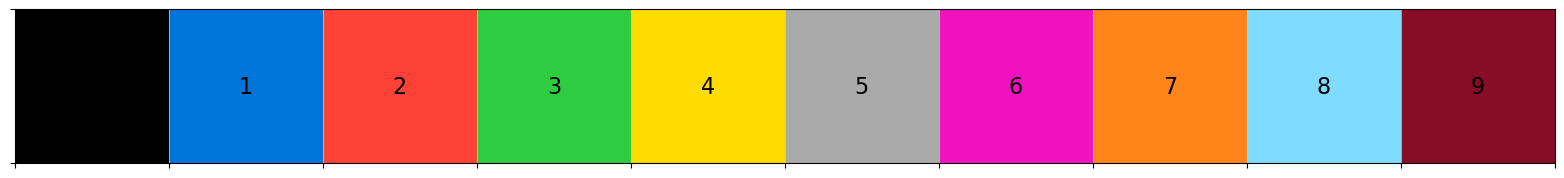

In [55]:
plot_grid([np.arange(10).tolist()], write_numbers=True)

017c7c7b


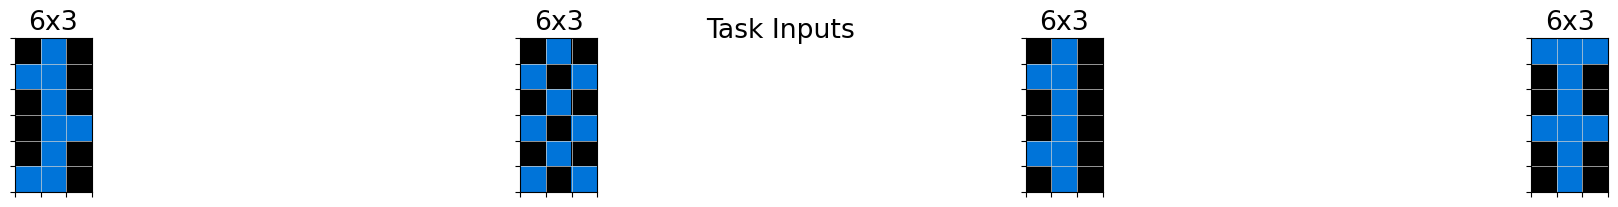

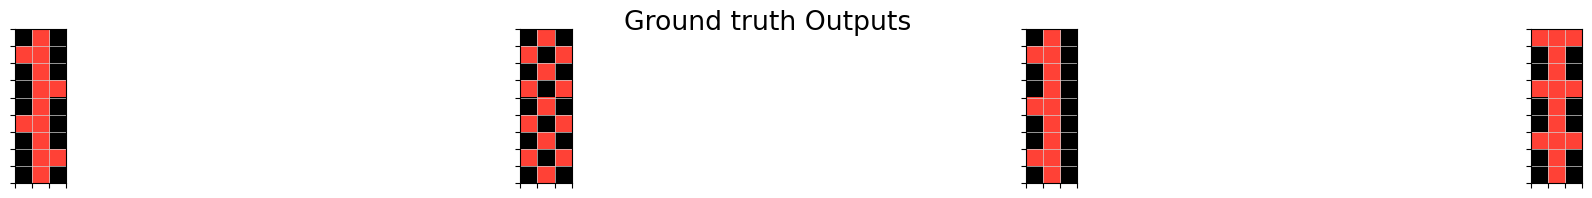

2024-09-16 18:01:42,260 - __main__ - WARNING - Input generation function not found


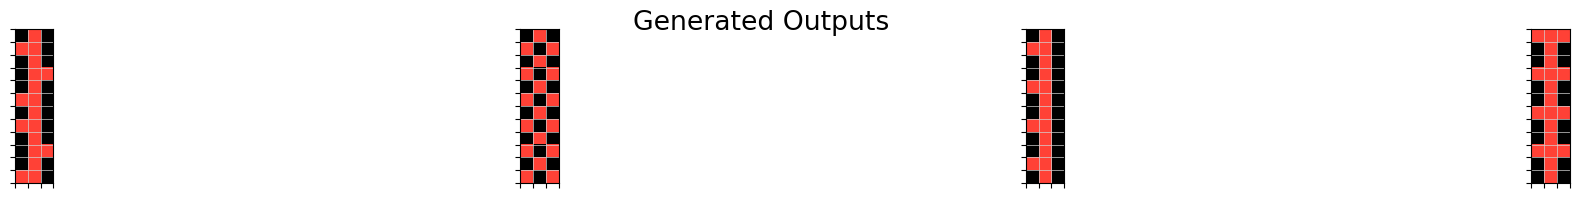

In [60]:
visualize_train_task(task_id=list(train_data.keys())[2])